In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sqlalchemy import create_engine
from sqlalchemy import MetaData
import sqlite3
import os, glob
import re, textwrap
import pickle, json, requests, urllib
from tqdm import tqdm

%matplotlib inline

sns.set(rc={'figure.figsize':(12, 9)})

In [106]:
def prepare_bikes(data):
    '''
    Prepare data frame for further process. 
    Change column names, compute distance and speed for each trip.
    '''
    
    data1 = data.copy()
    
    data1.columns = ['tripduration', 'starttime', 'stoptime', 'ss_id',
       'ss_name', 'ss_lat', 'ss_lon', 'es_id', 'es_name',
       'es_lat', 'es_lon', 'bikeid', 'usertype',
       'by', 'gender']
    
    data1["starttime"] = pd.to_datetime(data1["starttime"])
    data1["stoptime"] = pd.to_datetime(data1["stoptime"])
    data1['day'] = data1['starttime'].dt.weekday_name
    
    
    data1['tripduration_min'] = data1['tripduration'] / 60
    
    
    return data1

In [161]:
def private_data(data):
    '''
    Prepare statistics about entries without precisied gender, without birthyear and fake birthyear
    '''
    unknown = len(data.loc[data['gender'] == 0, :])
    wo_by = len(data.loc[data['by'].isna(), :])
    too_old = len(data.loc[data['by'] <= 1950])
    
    return unknown, wo_by, too_old

In [14]:
path = os.path.join('.', 'data')

unknown = []
wo_by = []
too_old = []
titles = []

#application of private_data to all csv files

for s in tqdm(os.listdir(path)):
    # save names of analyzed files
    titles.append(s)
    
    # loading
    data = pd.read_csv(os.path.join('.', 'data', s),
                       compression = 'zip')
    
    data = prepare_bikes(data)
    
    u, w, t = private_data(data)
    unknown.append(u)
    wo_by.append(w)
    too_old.append(t)
    

for i in range(len(titles)):
    titles[i] = titles[i][:4] + '-' + titles[i][4:6]

100%|██████████| 24/24 [04:44<00:00, 12.62s/it]


In [170]:
priv_data = dict({'titles': titles,
          'unknown': unknown,
          'wo_by': wo_by,
          'too_old' : too_old})

priv_data = pd.DataFrame.from_dict(priv_data).sort_values(by = 'titles')
priv_data.head()

titles  unknown   wo_by  too_old
2   2017-01    31835   29076    11576
9   2017-02    52018   49323    12226
5   2017-03    35438   32846    11246
23  2017-04   172823  168672    17117
13  2017-05   177580  172823    18622

In [26]:
with open('priv_data.pkl', 'wb') as output:
    pickle.dump(priv_data, output)

In [107]:
with open('priv_data.pkl', 'rb') as inp:
    priv_data = pickle.load(inp)

In [131]:
priv_data.head()

titles  unknown   wo_by  too_old
2   2017-01    31835   29076    11576
9   2017-02    52018   49323    12226
5   2017-03    35438   32846    11246
23  2017-04   172823  168672    17117
13  2017-05   177580  172823    18622

In [108]:
priv_data_melt = priv_data.melt(id_vars = 'titles')
priv_data_melt.head()

titles variable   value
0  2017-01  unknown   31835
1  2017-02  unknown   52018
2  2017-03  unknown   35438
3  2017-04  unknown  172823
4  2017-05  unknown  177580

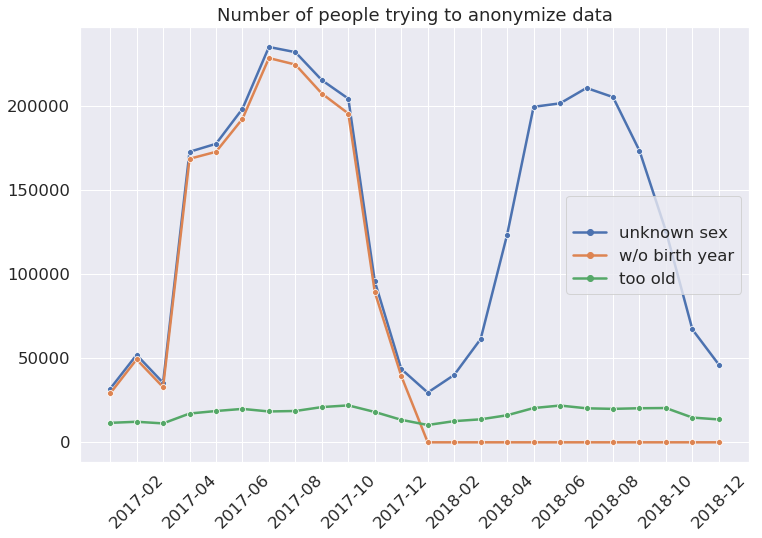

In [129]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
priv_data_plot = sns.lineplot(data = priv_data_melt, x = 'titles', y = 'value', hue = 'variable',
                             markers = ['o', 'o', 'o'], style = 'variable', dashes = False)

# force plot
priv_data_plot.figure.canvas.draw()

# rotate labels and print half of dates
labels = priv_data_plot.get_xticklabels()
for i in range(len(labels)):
    if i%2==0:
        labels[i].set_text('')
priv_data_plot.set_xticklabels(labels, rotation=45)


# labels and titles
priv_data_plot.set(xlabel='', ylabel='', title = 'Number of people trying to anonymize data')
# custom legend
leg = priv_data_plot.get_legend()
new_labels = ['', 'unknown sex', 'w/o birth year', 'too old']
for t, l in zip(leg.texts, new_labels): 
    t.set_text(l)


In [130]:
priv_data_plot.get_figure().savefig('priv_data_plot.png')

In [19]:
def over_day(data):
    '''
    Get all trips longer than 24 hours
    '''
    data_over_day = data.loc[data['tripduration_min'] > 60*24, :].copy()
    
    return data_over_day

In [20]:
path = os.path.join('.', 'data')

titles = []
over_one_day = pd.DataFrame()

# application of over_day to all csv files
for s in tqdm(os.listdir(path)):
    # save names of analyzed files
    titles.append(s)
    
    # loading
    data = pd.read_csv(os.path.join('.', 'data', s),
                       compression = 'zip')
    
    data = prepare_bikes(data)
    
    over_one_day = over_one_day.append(over_day(data))
    

100%|██████████| 24/24 [04:40<00:00, 13.09s/it]


In [21]:
with open('over_one_day.pkl', 'wb') as output:
    pickle.dump(over_one_day, output)

In [5]:
with open('over_one_day.pkl', 'rb') as inp:
    over_one_day = pickle.load(inp)

In [159]:
ood_gender = pd.DataFrame(over_one_day['gender'].value_counts())
ood_gender.index = ['male', 'unknown', 'female']
ood_gender = ood_gender.reset_index()
ood_gender

index  gender
0     male    4094
1  unknown    2768
2   female    1831

In [160]:
with open('ood_gender.pkl', 'wb') as output:
    pickle.dump(ood_gender, output)

In [152]:
with open('ood_gender.pkl', 'rb') as f:
    ood_gender = pickle.load(f)

In [158]:
ood_utype = pd.DataFrame(over_one_day['usertype'].value_counts())
ood_utype = ood_utype.reset_index()
ood_utype

index  usertype
0    Customer      5363
1  Subscriber      3324

In [146]:
with open('ood_utype.pkl', 'wb') as output:
    pickle.dump(ood_utype, output)

In [164]:
# most popular long trips station
ood = over_one_day.groupby(['ss_id']).size().reset_index()
ood.columns = ['ss_id', 'counter']
ood_max = ood.loc[ood['counter'] >= 50]
print(ood_max.shape) 
ood_max.head()

(21, 2)


ss_id  counter
152   387.0       57
195   436.0       62
196   437.0       76
296  2006.0       56
308  3041.0      107

In [171]:
df = pd.read_csv('./data/201812-citibike-tripdata.csv.zip', compression = 'zip')
data = prepare_bikes(df)

In [174]:
stations = data.loc[:, ['ss_id', 'ss_name']].drop_duplicates()

ood_max_names = pd.merge(ood_max, stations, on = 'ss_id', how = 'left').sort_values(by = 'counter', ascending = False)

ood_max_names = ood_max_names.reset_index(drop = True)
ood_max_names = ood_max_names[[ 'ss_name', 'counter']]
ood_max_names.columns = ['station name', 'counter']
ood_max_names.head(10)

station name  counter
0       Fulton St & Utica Ave      198
1      Humboldt St & Varet St      124
2  Kingston Ave & Herkimer St      107
3        Lenox Ave & W 130 St      106
4    Halsey St & Tompkins Ave       98
5      Albany Ave & Fulton St       85
6        Lenox Ave & W 115 St       84
7   Lewis Ave & Kosciuszko St       83
8     Macon St & Nostrand Ave       76
9        Stagg St & Union Ave       75

In [133]:
with open('ood_max_names.pkl', 'wb') as output:
    pickle.dump(ood_max_names, output)

In [80]:
def money(data):
    '''
    What fraction of  earnigs would be long trips if paid
    '''
    customers = data.loc[data['usertype'] == 'Customer', 'tripduration_min']
    subscribers = data.loc[data['usertype'] == 'Subscriber', 'tripduration_min']

    customers_long = customers[customers > 60*24]
    subscribers_long = subscribers[subscribers > 60*24]
    customers_money = np.sum(np.ceil(customers/30) * 3)
    subscribers_money = np.sum(np.ceil(np.maximum(((subscribers - 45)/15), 0)) * 2.5)

    customers_long_money = np.sum(np.ceil(customers_long/30) * 3)
    subscribers_long_money = np.sum(np.ceil((subscribers_long - 45)/15) * 2.5)
    
    return customers_long_money/customers_money, subscribers_long_money/subscribers_money


In [82]:
path = os.path.join('.', 'data')

titles = []
cust = []
subs = []

# application of function money to all csv filess
for s in tqdm(os.listdir(path)):
    # save names of analyzed files
    titles.append(s)
    
    # loading
    data = pd.read_csv(os.path.join('.', 'data', s),
                       compression = 'zip')
    
    data = prepare_bikes(data)
    
    result = money(data)
    
    cust.append(result[0])
    subs.append(result[1])
    

100%|██████████| 24/24 [04:15<00:00, 12.24s/it]


In [86]:
for i in range(len(titles)):
    titles[i] = titles[i][:4] + '-' + titles[i][4:6]

In [156]:
df_money = pd.DataFrame.from_dict({'month':titles, 
                       'customers': cust,
                       'subscribers': subs})
df_money = df_money.sort_values(by = 'month')

In [157]:
with open('money_long.pkl', 'wb') as output:
    pickle.dump(df_money, output)

In [89]:
df_money_melt = df_money.melt(id_vars = 'month', var_name = 'user type', value_name = 'money fraction')
df_money_melt.head()

month  user type  money fraction
0  2018-02  customers        0.554943
1  2018-01  customers        0.525858
2  2017-01  customers        0.238266
3  2018-11  customers        0.169300
4  2017-07  customers        0.162993

[Text(68.25, 0.5, 'long money fraction'), Text(0.5, 52.5, 'months')]

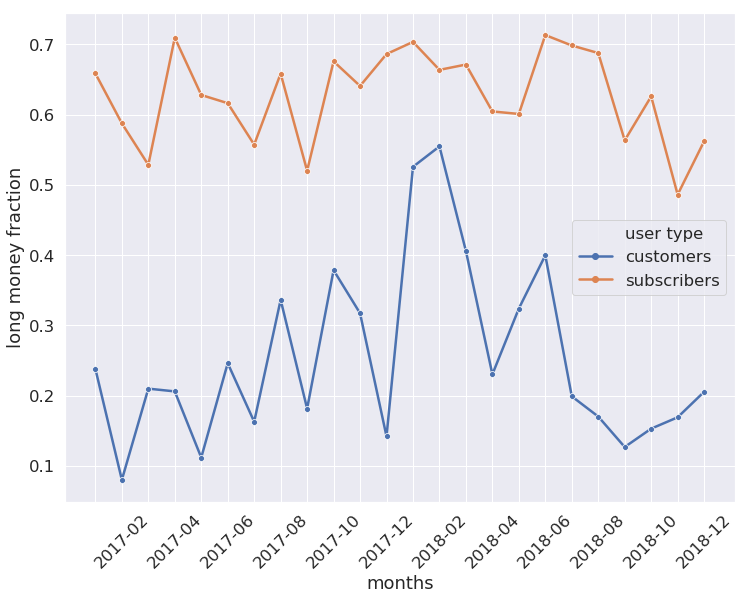

In [92]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
money_plot = sns.lineplot(data = df_money_melt, x = 'month', y = 'money fraction', hue = 'user type',
                         markers = ['o', 'o'], style = 'user type', dashes = False)


# force plot
money_plot.figure.canvas.draw()

# rotate labels and print half of dates
labels = money_plot.get_xticklabels()
for i in range(len(labels)):
    if i%2==0:
        labels[i].set_text('')
money_plot.set_xticklabels(labels, rotation=45)

# labels
money_plot.set(xlabel='months', ylabel='long money fraction')

In [167]:
money_plot.get_figure().savefig('money_plot.png')